In [40]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
%matplotlib inline

In [41]:
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = int(img.shape[0]*.67)
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]*1
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
def downsample(cars,ncars):
    indexx=[]
    index=[]
    ncarss=[]
    for i in range(len(cars)):
        index.append(i)
    for i in range(len(index)):
        k=np.random.randint(0,len(index))
        ncarss.append(ncars[k])
        del index[k]
    return ncarss
nx=9
ny=6

def calibrate(nx,ny):
    undist=[]
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    image_store=[]
    image=[]
    undst=[]
    global ret, mtx ,dist ,rvecs ,tvecs
    images = glob.glob('camera_cal/calibration*.jpg')
    k=0
    l=0
    for fname in images:
        k+=1
        img = cv2.imread(fname)
        image.append(img)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        image_store.append(img)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)      
            l+=1
    ret, mtx ,dist ,rvecs ,tvecs = cv2.calibrateCamera(objpoints,imgpoints,(gray.shape[0],gray.shape[1]),None,None)
    return ret, mtx, dist, rvecs, tvecs

def undistort(image,mtx,dist,):        
    undist=cv2.undistort(image,mtx,dist,None,mtx)
    return undist

In [42]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [43]:
# Read in our vehicles and non-vehicles
images = glob.glob('C://Users/matth/CarND-Vehicle-Detection-master/non-vehicles/Extras/*.jpg')
cars = []
notcars = []

for image in images:
    if 'images' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        

In [44]:
data_info = data_look(cars, notcars)


In [45]:
nncarss=downsample(cars,notcars)
 

In [46]:
print(len(notcars))
print(len(cars))

8967
7391


Your function returned a count of 7391  cars and 8967  non-cars
of size:  (64, 64, 3)  and data type: uint8


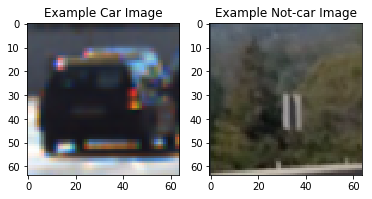

In [47]:
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

In [80]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 15  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32,32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()


In [81]:
t=time.time()


car_features=extract_features(cars, color_space=color_space, spatial_size=spatial_size,hist_bins=hist_bins, orient=orient,pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block,spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat,hog_channel=hog_channel)
notcar_features=extract_features(nncarss, color_space=color_space, spatial_size=spatial_size,hist_bins=hist_bins, orient=orient,pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block,spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat,hog_channel=hog_channel)
t2=time.time()
print(round(t2-t, 2), 'Seconds to extract all features...')

104.16 Seconds to extract all features...


In [82]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
#, random_state=rand_state
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))




Using: 15 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 11988
157.58 Seconds to train SVC...
Test Accuracy of SVC =  0.9973


In [83]:
# Check the prediction time for a single sample

t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

My SVC predicts:  [ 1.  0.  1.  1.  1.  1.  0.  0.  1.  0.  1.  1.  0.  1.  0.  1.  1.  0.
  1.  1.  1.  0.  0.  1.  1.  1.  0.  1.  1.  0.  1.  1.  1.  1.  0.  1.
  1.  1.  0.  1.  0.  1.  1.  1.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.
  1.  1.  1.  1.  0.  1.  0.  1.  1.  1.]
For these 100 labels:  [ 1.  0.  1.  1.  1.  1.  0.  0.  1.  0.  1.  1.  0.  1.  0.  1.  1.  0.
  1.  1.  1.  0.  0.  1.  1.  1.  0.  1.  1.  0.  1.  1.  1.  1.  0.  1.
  1.  1.  0.  1.  0.  1.  1.  1.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.
  1.  1.  1.  1.  0.  1.  0.  1.  1.  1.]
0.07382 Seconds to predict 100 labels with SVC


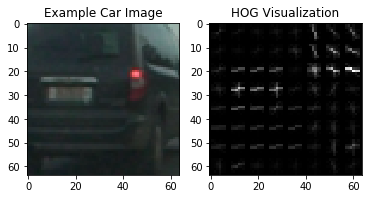

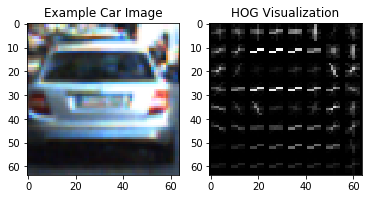

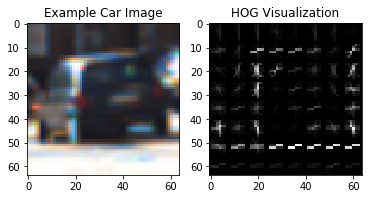

In [84]:

for i in range (3):
# Generate a random index to look at a car image
    ind = np.random.randint(0, len(cars))
# Read in the image
    image = mpimg.imread(cars[ind])
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
    orient = 15
    pix_per_cell = 8
    cell_per_block = 2
# Call our function with vis=True to see an image output
    features, hog_image = get_hog_features(gray, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)

# Plot the examples

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(image, cmap='gray')
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization')
    #cv2.imwrite('HOG Extracion.png',img)
    #kk=np.concatenate(image,hog_image)
    #plt.imshow(kk)

time: 1.0362555980682373for number of windows: 195
time: 1.0178430080413818for number of windows: 195
time: 1.257476806640625for number of windows: 195
time: 1.01877760887146for number of windows: 195
time: 0.9883100986480713for number of windows: 195
time: 0.9575557708740234for number of windows: 195


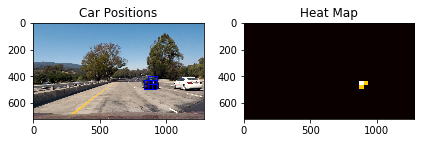

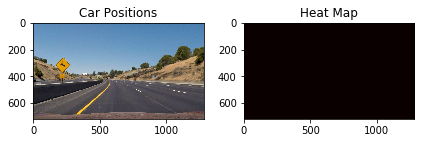

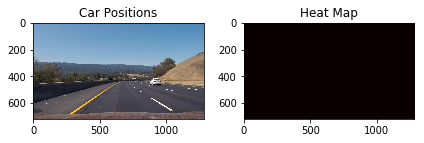

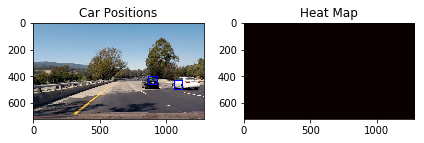

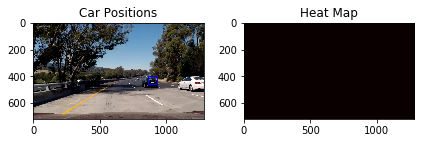

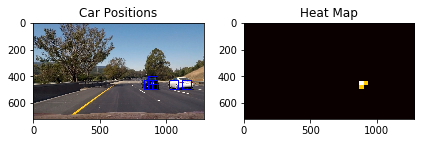

In [88]:
from scipy.ndimage.measurements import label

for i in range(1,7):
    
    image = mpimg.imread('test_images/test'+str(i)+'.jpg')

    draw_image = np.copy(image)
    t=time.time()
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,592], 
                        xy_window=(64,64), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)        

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    t2=time.time()
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    print("time: "+str(t2-t)+"for number of windows: "+str(len(windows)))
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(window_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()


time: 113.12105584144592for number of windows: 20


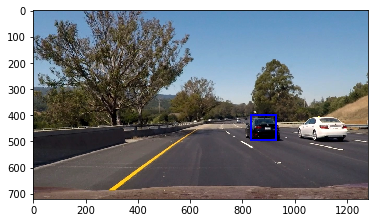

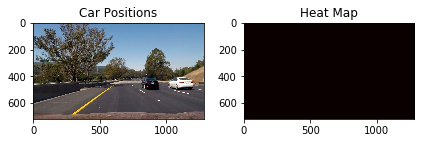

In [87]:
image = mpimg.imread('test6.jpg')
#image = image.astype(np.float32)/255
#image = image.astype(np.float32)/255
y_start_stop=[400,528]
windows = slide_window(image, x_start_stop=[256,1280], y_start_stop=y_start_stop, 
                    xy_window=(96,96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   
t2=time.time()

heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)

draw_img = draw_labeled_bboxes(np.copy(image), labels)
print("time: "+str(t2-t)+"for number of windows: "+str(len(windows)))
plt.imshow(window_img)
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

Exception ignored in: <bound method VideoFileClip.__del__ of <moviepy.video.io.VideoFileClip.VideoFileClip object at 0x0000019EFBB6A080>>
Traceback (most recent call last):
  File "C:\Users\matth\Miniconda3\envs\carnd-term1\lib\site-packages\moviepy\video\io\VideoFileClip.py", line 90, in __del__
    del self.reader
AttributeError: reader


NameError: name 'draw_img' is not defined

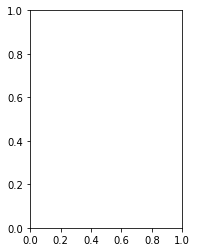

In [61]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
print(len(draw_img[2]))

In [14]:
from collections import deque
d = deque(maxlen=10)


In [69]:
def slidewindoww(image,iteration):
    windoww=[]
    draw_image = np.copy(image)
    for i in range (iteration):
        windows = slide_window(image, x_start_stop=[256+64*i,1280], y_start_stop=[400,656-64*i], 
                            xy_window=(160-32*i,160-32*i), xy_overlap=(0.6,0.6))

        hot_windows = search_windows(image, windows, svc, X_scaler, color_space='YCrCb', 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)                       
        
        for j in hot_windows:
            windoww.append(j)
    window_img = draw_boxes(draw_image, windoww, color=(0,255,0), thick=6)      
    return window_img, windoww

time: 0.47676706314086914for number of windows: 7
time: 0.4466679096221924for number of windows: 0
time: 0.43813300132751465for number of windows: 1
time: 0.45922160148620605for number of windows: 5
time: 0.4436795711517334for number of windows: 6
time: 0.4426765441894531for number of windows: 7


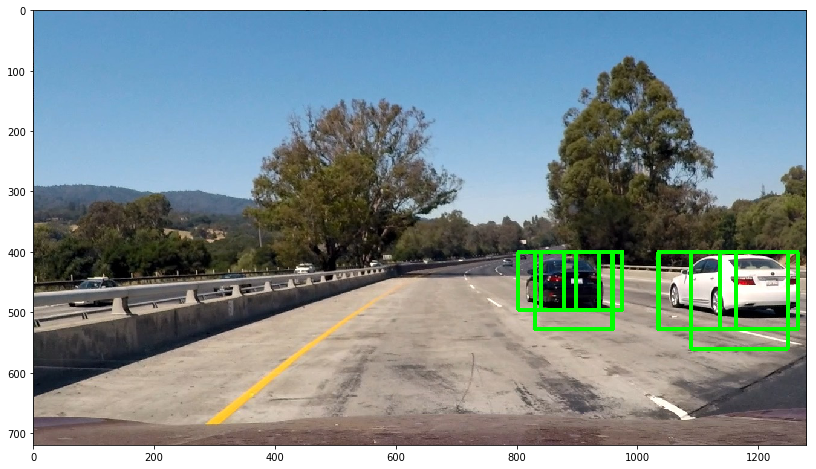

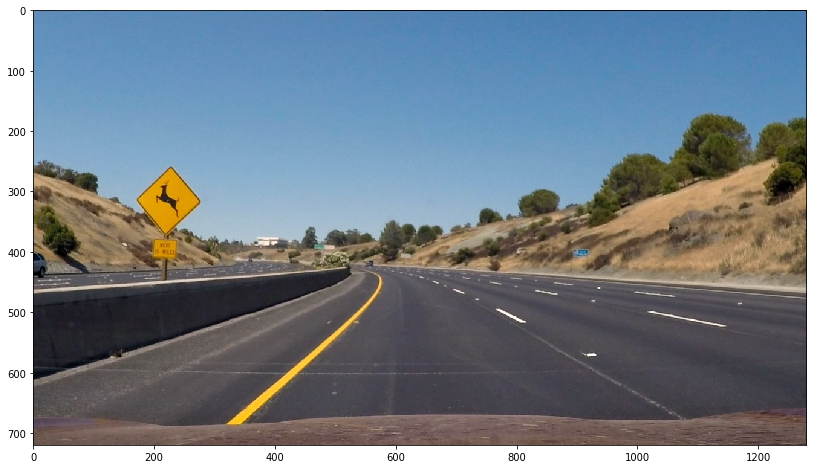

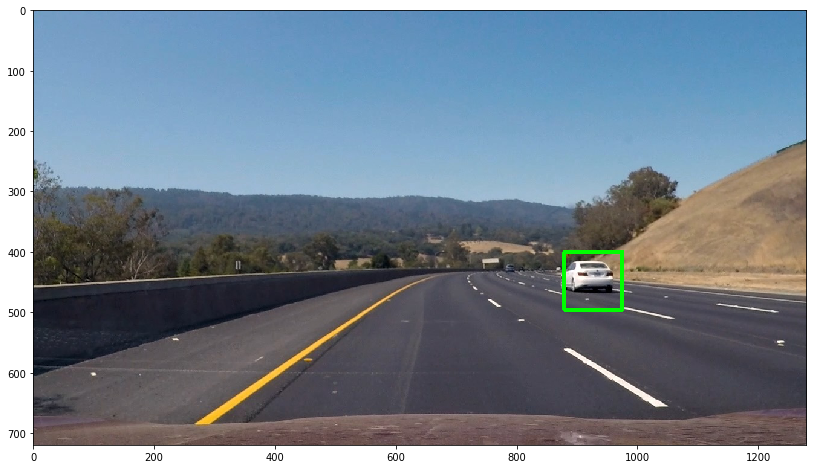

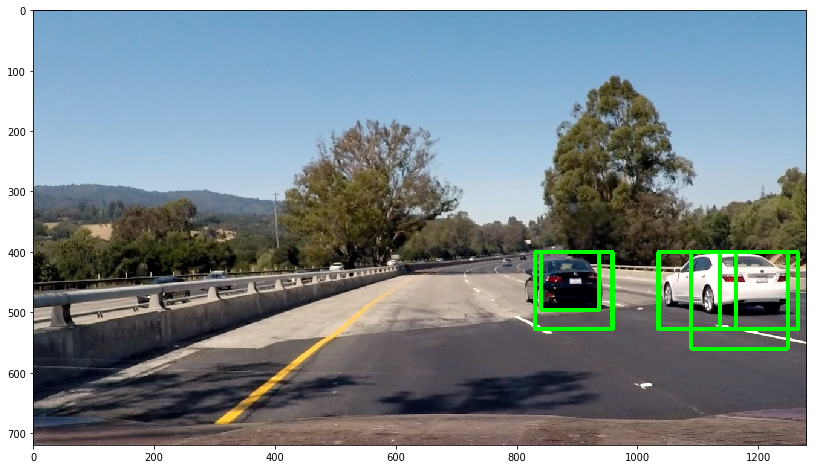

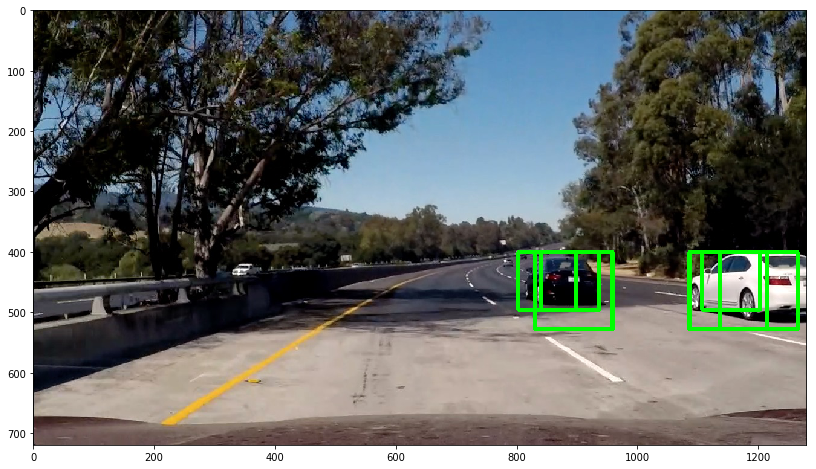

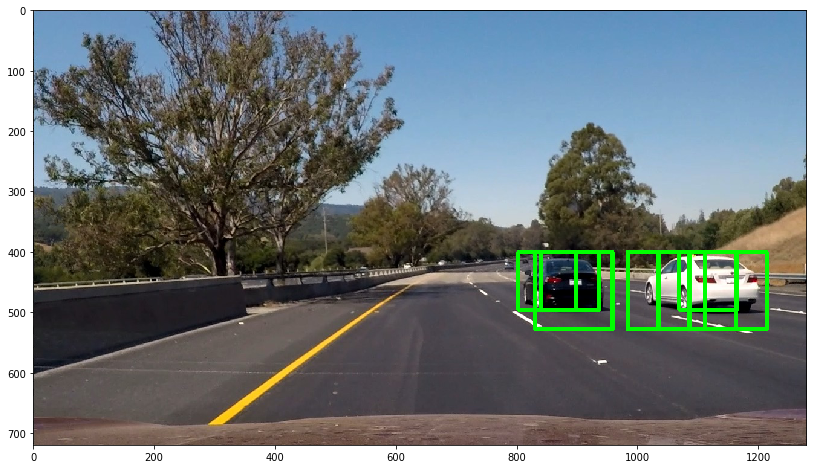

In [92]:
for i in range(1,7):
    t=time.time()
    image = mpimg.imread('test_images/test'+str(i)+'.jpg')
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)

    #image = image.astype(np.float32)/255


    kkkk=slidewindoww(image,3)
    t2=time.time()
    print("time: "+str(t2-t)+"for number of windows: "+str(len(kkkk[1])))
    plt.figure(figsize=(16,8))
    plt.imshow(kkkk[0])

In [116]:
def hotimage(image):
    global prev

    flattened=[]
    res=slidewindoww(image,3)
    flattened=res[1]
    
    k=res[0]
    k= k.astype(np.float32)/255
    heat = np.zeros_like(k[:,:,0]).astype(np.float)
    
    if not flattened and prev is None:
        flattened=[]
    elif flattened:
        prev=flattened  
    else:
        flattened=prev
        
    currheat = add_heat(heat,flattened)
    d.append(currheat)
    heat_sum=sum(d)#/len(d)
    
    heatt = apply_threshold(heat_sum,2)
    labels = label(heatt)
    #print(labels)
    heatmap = np.clip(heatt, 0, 255)
    heatt=[]
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    draw=draw_boxes(np.copy(image), flattened, color=(0, 0, 255), thick=6)
   
    return draw_img, heatmap,draw

time: 1.7498106956481934for number of windows: 720
time: 1.881054162979126for number of windows: 720
time: 1.8005828857421875for number of windows: 720
time: 1.6099438667297363for number of windows: 720
time: 1.613837718963623for number of windows: 720
time: 2.0251243114471436for number of windows: 720


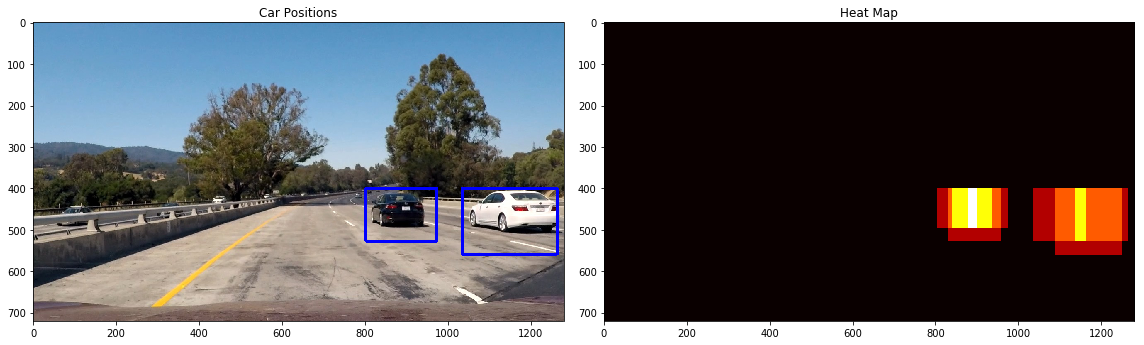

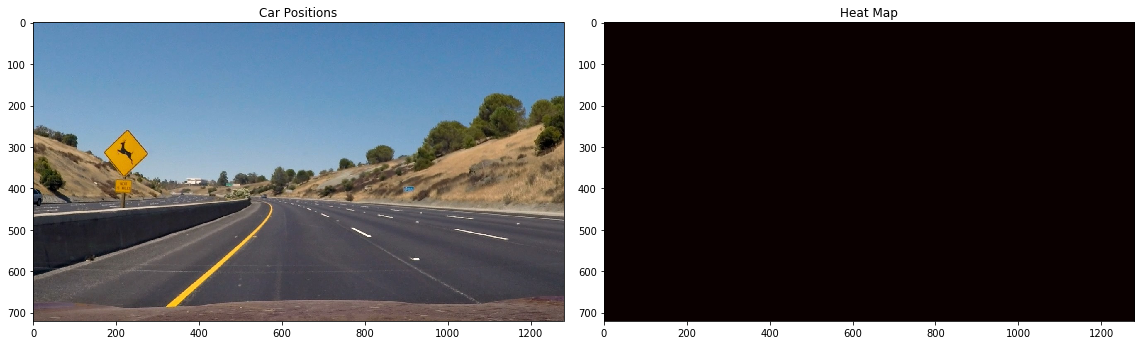

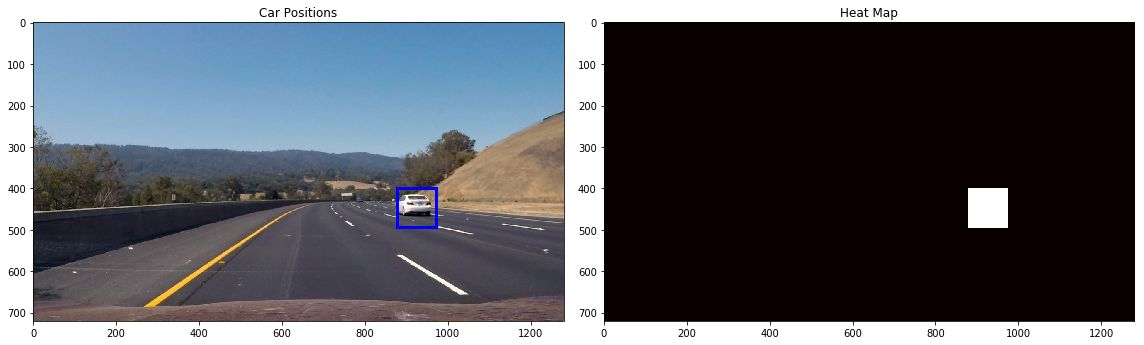

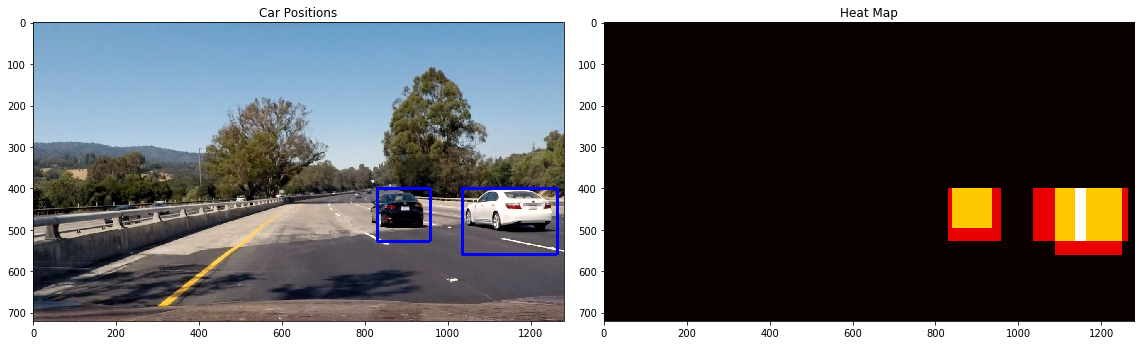

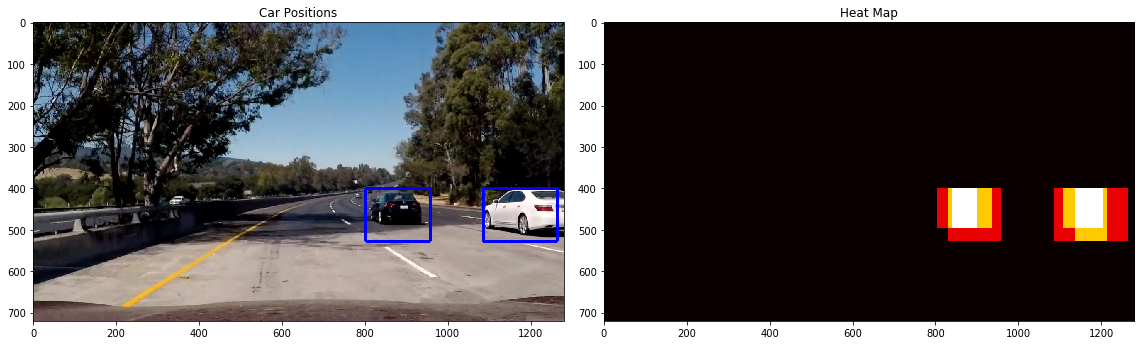

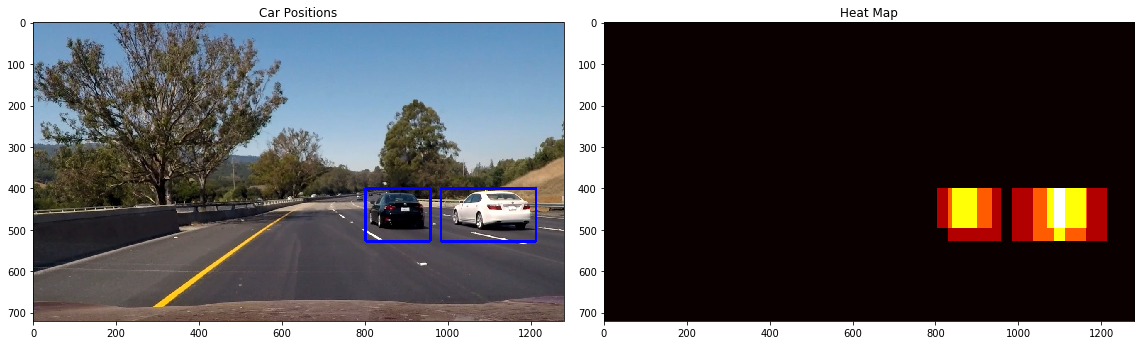

In [119]:

for i in range(1,7):
    g=[]
    heatmap=[]
    d=[]
    t=time.time()
    prev=[]
    d = deque(maxlen=10)
    image = mpimg.imread('test_images/test'+str(i)+'.jpg')
    for j in range(3):
    
        
        g=hotimage(image)

    fig = plt.figure(figsize=(16,12))
    plt.subplot(121)
    plt.imshow(g[0])
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(g[1], cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    t2=time.time()
    print("time: "+str(t2-t)+"for number of windows: "+str(len(k[2])))
    d=[]
    heatmap=[]
    g=[]
#,xstart,xstop

In [ ]:
fin=slidewindoww(image,2)
plt.imshow(fin[0])

In [95]:
flatten=[]

In [64]:
from scipy.ndimage.measurements import label
t=time.time()

prev=None
d = deque(maxlen=8)

def pipeline(image):
    
    out_img = hotimage(image)
    
    #height, width = 720, 1280
    #kk=np.dstack((out_img[1], out_img[1],out_img[1]))

    #Screen=np.zeros((height, width, 3), dtype=np.uint8)
    #Screen[0:720,0:960] = cv2.resize(out_img[0], (int(width*3/4),int(height)), interpolation=cv2.INTER_AREA)    
    #Screen[0:240,960:1280] = cv2.resize(out_img[0], (320,240), interpolation=cv2.INTER_AREA)
    #Screen[240:480,960:1280] = cv2.resize(kk, (320,240), interpolation=cv2.INTER_AREA)
    #Screen[480:720,960:1280] = cv2.resize(out_img[2], (320,240), interpolation=cv2.INTER_AREA)
    return out_img[0]

t2=time.time()
print(str(t2-t))

0.0


In [97]:
heatmap=[]
flattened=[]

In [ ]:
#################### Implement multi scale windows
t=time.time()

image = mpimg.imread('test6.jpg')

kk=pipeline(image)
plt.imshow(kk)
t2=time.time()
print(str(t2-t))

In [31]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
nx,ny=9,6
calib=calibrate(nx,ny)
mtx=calib[1]
dist=calib=[2]

In [ ]:
d = deque(maxlen=10)

white_output = "projectffffin.mp4"

clip1 = VideoFileClip("project_video.mp4").subclip(25,30)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [39]:
d = deque(maxlen=10)
white_output = "projectfinishcalib.mp4"
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

OSError: [WinError 6] Das Handle ist ungültig

In [ ]:
dirname="C://Users/matth/CarND-Vehicle-Detection-master/test_images/test"
for i in range(1,7):
    image=mpimg.imread("C://Users/matth/CarND-Vehicle-Detection-master/test_images/test"+str(i)+".jpg")
    plt.figure(figsize=(6,4))
    k=slidewindoww(image,3)
    #k=image
    plt.imshow(k)